# IBM Data Science, Capstone Project

# RBR's Battle of Neighborhood-Final

## Exploring business opportunities in setting up Food joint by exploring venues of Banglore, India.

In [1]:
# importing supporting libraries
import pandas as pd
import numpy as np
# for scraping a webpage
from bs4 import BeautifulSoup
import requests
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
print('Libraries imported!')

Libraries imported!


In [2]:
# Scraping a wikipedia page
url = 'https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Bangalore'
html_file = requests.get(url).text
soup = BeautifulSoup(html_file,'html.parser')
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of neighbourhoods in Bangalore - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"Xq7cQwpAAD4AAAP7qxgAAAAJ","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_neighbourhoods_in_Bangalore","wgTitle":"List of neighbourhoods in Bangalore","wgCurRevisionId":948839980,"wgRevisionId":948839980,"wgArticleId":53117184,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Use dmy dates from August 2017","Use Indian English from August 2017","All Wikipedia articles wr

#### Finding Regions and Neighborhoods in Banglore city

In [3]:
Region = []
for reg in soup.find_all('span',class_ = 'mw-headline'):
        Region.append(reg.text)
del Region[8:11]
print(Region)

['Central', 'Eastern', 'North-Eastern', 'Northern', 'South-Eastern', 'Southern', 'Southern suburbs', 'Western']


In [4]:
#counting number of Neighborhoods
dfreg = []
dfarea = []
i = 0
for area1 in soup.find_all('table',class_='wikitable sortable'):
    for area2 in area1.find_all('td'):
        dfarea.append(area2.text.strip())
        dfreg.append(Region[i])
    i = i+1
dfreg = dfreg[::3]        
dfarea = dfarea[::3]
print(len(dfreg))
print(len(dfarea))

65
65


In [5]:
list_df = ['Region','Neighborhood']
df = pd.DataFrame(columns = list_df)
df['Region'] = dfreg
df['Neighborhood'] = dfarea
#pd.set_option("display.max_rows", None, "display.max_columns", None)
df.head()

,Region,Neighborhood
0,Central,Cantonment area
1,Central,Domlur
2,Central,Indiranagar
3,Central,Jeevanbheemanagar
4,Central,Malleswaram


#### Finding Lat Long coordinates of Regions and Neighborhoods in Banglore city

In [7]:
df_Header = ['Latitude', 'Longitude']
banglore_csv = 'Bang_Coords.csv'
banglore_coord = pd.read_csv(banglore_csv, names = df_Header)
banglore_coord.head()

,Latitude,Longitude
0,12.9936,77.5981
1,12.9610,77.6387
2,12.9784,77.6408
3,12.9642,77.6581
4,12.0055,77.5692


In [8]:
df_lat_long = df.join(banglore_coord)
df_lat_long.head()

,Region,Neighborhood,Latitude,Longitude
0,Central,Cantonment area,12.9936,77.5981
1,Central,Domlur,12.9610,77.6387
2,Central,Indiranagar,12.9784,77.6408
3,Central,Jeevanbheemanagar,12.9642,77.6581
4,Central,Malleswaram,12.0055,77.5692


#### Creating map of Banglore city showing Neighborhood venues

In [9]:
address = 'Bengaluru, Karnataka'
geolocator = Nominatim(user_agent="Beng")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bengaluru are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bengaluru are 12.9791198, 77.5912997.


In [211]:
import folium
# create map of Banglore using latitude and longitude values
map_banglore = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_lat_long['Latitude'], df_lat_long['Longitude'], df_lat_long['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_banglore)  
fig.write_html('Banglore.html')    
map_banglore


In [105]:
CLIENT_ID = 'AWUZFHT5NOCVXSNFCM0EUXAO5REZT5UQWSO4GUGBJZPMPZFK' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=100
print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)

My credentails:
CLIENT_ID: AWUZFHT5NOCVXSNFCM0EUXAO5REZT5UQWSO4GUGBJZPMPZFK


In [106]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Region', #Neighborhood is Region
                  'Region Latitude', 
                  'Region Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [107]:
banglore_venues = getNearbyVenues(names=df_lat_long['Region'],
                                   latitudes=df_lat_long['Latitude'],
                                   longitudes=df_lat_long['Longitude']
                                  )

Central
Central
Central
Central
Central
Central
Central
Central
Central
Central
Central
Eastern
Eastern
Eastern
Eastern
Eastern
Eastern
Eastern
Eastern
North-Eastern
North-Eastern
North-Eastern
North-Eastern
North-Eastern
North-Eastern
North-Eastern
Northern
Northern
Northern
Northern
Northern
Northern
Northern
Northern
South-Eastern
South-Eastern
South-Eastern
South-Eastern
South-Eastern
South-Eastern
South-Eastern
Southern
Southern
Southern
Southern
Southern
Southern
Southern
Southern
Southern suburbs
Southern suburbs
Southern suburbs
Southern suburbs
Southern suburbs
Southern suburbs
Western
Western
Western
Western
Western
Western
Western
Western
Western
Western


#### Determining Venues, Category and its count

In [108]:
banglore_venues = banglore_venues[banglore_venues['Venue Category'] != 'Neighborhood']
print(banglore_venues.shape)

(2804, 7)


In [109]:
print('There are {} uniques categories.'.format(len(bengaluru_venues['Venue Category'].unique())))

There are 217 uniques categories.


In [110]:
bengaluru_venues.groupby('Region')['Venue Category'].nunique().to_frame().sort_values('Venue Category', ascending = False)

,Venue Category
Region,
Central,134
South-Eastern,98
Southern,93
Eastern,90
Western,79
Northern,60
North-Eastern,59
Southern suburbs,57


In [111]:
v_count = banglore_venues.groupby('Region')['Venue Category'].value_counts().to_frame()
v_count.columns = ['Venue Count']
v_count.sort_values('Venue Count', ascending = False)
v_count

Venue Count
Region  Venue Category                 
Central Indian Restaurant           139
        Café                         59
        Hotel                        33
        Chinese Restaurant           26
        Pub                          25
...                                 ...
Western Supermarket                   1
        Tea Room                      1
        Thai Restaurant               1
        Theme Park                    1
        Travel & Transport            1

[668 rows x 1 columns]

In [21]:
v_count.head()

Venue Count
Region  Venue Category                 
Central Indian Restaurant           139
        Café                         59
        Hotel                        33
        Chinese Restaurant           26
        Pub                          25

In [112]:
v_count.columns

Index(['Venue Count'], dtype='object')

In [113]:
v_count  = v_count.reset_index()

In [114]:
import subprocess
import sys
def install(package):
    try:
        __import__(package)
    except ImportError as e:
        print("package not present...installing")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
install('plotly')
install('plotly.offline')
install('plotly.express')
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as po
import plotly.express as px

In [115]:
def unique(l1):
    '''
    returns the unique items in a list
    '''
    dup1 = []
    for item in l1:
        if item not in dup1:
            dup1.append(item)
    return dup1

def ret_unique_num(l1):
    '''
    returns the number of unique items in a list
    in the order of the unique function's list
    '''
    x = unique(l1)
    y = []
    for item in x:
        y.append(l1.count(item))
    return y

In [116]:
df_lat_long.head()

,Region,Neighborhood,Latitude,Longitude
0,Central,Cantonment area,12.9936,77.5981
1,Central,Domlur,12.9610,77.6387
2,Central,Indiranagar,12.9784,77.6408
3,Central,Jeevanbheemanagar,12.9642,77.6581
4,Central,Malleswaram,12.0055,77.5692


In [117]:
v_count.head()

,Region,Venue Category,Venue Count
0,Central,Indian Restaurant,139
1,Central,Café,59
2,Central,Hotel,33
3,Central,Chinese Restaurant,26
4,Central,Pub,25


In [118]:
v_count.columns

Index(['Region', 'Venue Category', 'Venue Count'], dtype='object')

In [119]:
fig = px.bar(v_count,x = 'Venue Category',y = 'Venue Count',color = 'Region')
fig.write_html('stalked_Region.html')
fig.show()

In [120]:
fig = px.bar(v_count,x = 'Region',y = 'Venue Count',color = 'Venue Category')
fig.write_html('stacked_cat.html')
fig.show()

#### Plotting Indian Restaurants in each region

In [31]:
v_count_I =v_count[(v_count['Venue Category'] == 'Indian Restaurant')]
v_count_I

,Region,Venue Category,Venue Count
0,Central,Indian Restaurant,139
134,Eastern,Indian Restaurant,38
224,North-Eastern,Indian Restaurant,38
283,Northern,Indian Restaurant,29
343,South-Eastern,Indian Restaurant,93
441,Southern,Indian Restaurant,87
533,Southern suburbs,Indian Restaurant,13
589,Western,Indian Restaurant,34


In [121]:
fig = px.bar(v_count_I,x = 'Region',y = 'Venue Count',color = 'Venue Category')
fig.write_html('IR_regionwise.html')
fig.show()

#### Plotting Hotels in each region

In [122]:
v_count_Hotel =v_count[(v_count['Venue Category'] == 'Hotel')]
v_count_Hotel

,Region,Venue Category,Venue Count
2,Central,Hotel,33
136,Eastern,Hotel,21
272,North-Eastern,Hotel,1
289,Northern,Hotel,6
356,South-Eastern,Hotel,7
471,Southern,Hotel,3
560,Southern suburbs,Hotel,2
602,Western,Hotel,5


In [124]:
fig = px.bar(v_count_Hotel,x = 'Region',y = 'Venue Count',color = 'Venue Category')
fig.write_html('Hotel_regionwise.html')
fig.show()

#### Plotting Cafe in each region

In [125]:
v_count_Café =v_count[(v_count['Venue Category'] == 'Café')]
v_count_Café

,Region,Venue Category,Venue Count
1,Central,Café,59
135,Eastern,Café,24
225,North-Eastern,Café,15
290,Northern,Café,5
344,South-Eastern,Café,37
442,Southern,Café,30
534,Southern suburbs,Café,8
591,Western,Café,16


In [126]:
fig = px.bar(v_count_Café,x = 'Region',y = 'Venue Count',color = 'Venue Category')
fig.write_html('Cafe_regionwise.html')
fig.show()

#### Plotting Pizza Placees in each region

In [127]:
v_count_Pizza =v_count[(v_count['Venue Category'] == 'Pizza Place')]
v_count_Pizza

,Region,Venue Category,Venue Count
9,Central,Pizza Place,16
140,Eastern,Pizza Place,8
227,North-Eastern,Pizza Place,12
286,Northern,Pizza Place,7
348,South-Eastern,Pizza Place,16
444,Southern,Pizza Place,22
535,Southern suburbs,Pizza Place,7
592,Western,Pizza Place,9


In [128]:
fig = px.bar(v_count_Pizza,x = 'Region',y = 'Venue Count',color = 'Venue Category')
fig.write_html('Pizza_place_regionwise.html')
fig.show()

In [213]:
v_count_CR =v_count[(v_count['Venue Category'] == 'Chinese Restaurant')]
v_count_CR

,Region,Venue Category,Venue Count
3,Central,Chinese Restaurant,26
143,Eastern,Chinese Restaurant,6
230,North-Eastern,Chinese Restaurant,8
287,Northern,Chinese Restaurant,6
349,South-Eastern,Chinese Restaurant,13
445,Southern,Chinese Restaurant,18
555,Southern suburbs,Chinese Restaurant,2
597,Western,Chinese Restaurant,6


In [214]:
fig = px.bar(v_count_CR,x = 'Region',y = 'Venue Count',color = 'Venue Category')
fig.write_html('CR_regionwise.html')
fig.show()

#### Obtaining Food joints only regionwise

In [129]:
v_count_food = pd.DataFrame()
options = ['Indian Restaurant','Chinese Restaurant','Asian Restaurant', 'Italian Restaurant',
          'Middle Eastern Restaurant','French Restaurant','Karnataka Restaurant','Mexican Restaurant',
          'Korean Restaurant','Mediterranean Restaurant','Bengali','Eastern European Restaurant',
          'South Indian Restaurant','Afghan Restaurant','American Restaurant','German Restaurant','Punjabi Restaurant',
          'Thai Restaurant','Turkish Restaurant','Udupi Restaurant','Kerala Restaurant','Rajasthani Restaurant',
          'Hyderabadi Restaurant','North Indian Restaurant','Swiss Restaurant','Tibetan Restaurant','Persian Restaurant',
          'Maharashtrian Restaurant'] 
for index,row in v_count.iterrows():
       if row['Venue Category'] in options:
            v_count_food=v_count_food.append(row)
v_count_food.head()

,Region,Venue Category,Venue Count
0,Central,Indian Restaurant,139.0
3,Central,Chinese Restaurant,26.0
12,Central,Asian Restaurant,12.0
15,Central,Italian Restaurant,11.0
22,Central,Middle Eastern Restaurant,8.0


In [130]:
fig = px.bar(v_count_food,x = 'Region',y = 'Venue Count',color = 'Venue Category')
fig.write_html('stalked_food_jts.html')
fig.show()

In [41]:
df_lat_long.head()

,Region,Neighborhood,Latitude,Longitude
0,Central,Cantonment area,12.9936,77.5981
1,Central,Domlur,12.9610,77.6387
2,Central,Indiranagar,12.9784,77.6408
3,Central,Jeevanbheemanagar,12.9642,77.6581
4,Central,Malleswaram,12.0055,77.5692


In [42]:
v_count

,Region,Venue Category,Venue Count
0,Central,Indian Restaurant,139
1,Central,Café,59
2,Central,Hotel,33
3,Central,Chinese Restaurant,26
4,Central,Pub,25
...,...,...,...
663,Western,Supermarket,1
664,Western,Tea Room,1
665,Western,Thai Restaurant,1
666,Western,Theme Park,1


In [43]:
central_coords = pd.DataFrame()
'''
options = ['Indian Restaurant','Chinese Restaurant','Asian Restaurant', 'Italian Restaurant',
          'Middle Eastern Restaurant','French Restaurant','Karnataka Restaurant','Mexican Restaurant',
          'Korean Restaurant','Mediterranean Restaurant','Bengali','Eastern European Restaurant',
          'South Indian Restaurant','Afghan Restaurant','American Restaurant','German Restaurant','Punjabi Restaurant',
          'Thai Restaurant','Turkish Restaurant','Udupi Restaurant','Kerala Restaurant','Rajasthani Restaurant',
          'Hyderabadi Restaurant','North Indian Restaurant','Swiss Restaurant','Tibetan Restaurant','Persian Restaurant',
          'Maharashtrian Restaurant']
'''
for index,row in df_lat_long.iterrows():
       if row['Region'] in 'Central':
            central_coords= central_coords.append(row)
central_coords.head()

,Latitude,Longitude,Neighborhood,Region
0,12.9936,77.5981,Cantonment area,Central
1,12.9610,77.6387,Domlur,Central
2,12.9784,77.6408,Indiranagar,Central
3,12.9642,77.6581,Jeevanbheemanagar,Central
4,12.0055,77.5692,Malleswaram,Central


In [44]:
central_coords.describe()

,Latitude,Longitude
count,11.000000,11.000000
mean,12.900127,77.611964
std,0.297582,0.039907
min,12.005500,77.544000
25%,12.971300,77.587050
50%,12.985700,77.605100
75%,12.991600,77.639750
max,13.046000,77.675100


#### Finding mid-point of Central Region

In [45]:
mean_central_coords=central_coords.mean(axis=0)
mean_central_coords

Latitude     12.900127
Longitude    77.611964
dtype: float64

#### Finding Chinese Restaurants in Central Region

In [203]:
c_lat=12.9001 #12.9936 
c_long=77.6119 #77.5981
search_query_IR = 'Chinese Restaurant'

radius = 1500
url_IR = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, c_lat, c_long, VERSION, search_query_IR, radius, LIMIT)
results_IR = requests.get(url_IR).json()


#### Venue categories and its count in Central region

In [60]:
central_v_count

,Region,Venue Category,Venue Count
0,Central,Indian Restaurant,139
1,Central,Café,59
2,Central,Hotel,33
3,Central,Chinese Restaurant,26
4,Central,Pub,25
...,...,...,...
129,Central,Tex-Mex Restaurant,1
130,Central,Thai Restaurant,1
131,Central,Toy / Game Store,1
132,Central,Turkish Restaurant,1


#### Getting Venues Chinese Restaurants in Central Region

In [204]:
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # JSON files manipulation
venues_IR = results_IR['response']['venues']

# tranform venues into a dataframe and merging both data

dataframe_IR = json_normalize(venues_IR)

df_IR = pd.concat([dataframe_IR])

print("There are {} Chinese Restaurants in the Central Region".format(df_IR.shape[0]))

There are 26 Chinese Restaurants in the Central Region


c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



In [205]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in df_IR.columns if col.startswith('location.')] + ['id']
dataframe_filtered = df_IR.loc[:, filtered_columns]

# function that extracts the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

    
# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

  
# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

#dataframe_filtered
cr_df=dataframe_filtered[['name','categories','distance','lat','lng','id']]


#### Map of Chinese Restaurants in Central region

In [206]:
cr_map = folium.Map(location=[c_lat, c_long], zoom_start=16) # generate map centred arount Central Region

# add a red circle marker to represent the core location of Banglore
folium.CircleMarker(
    [c_lat, c_long],
    radius=10,
    color='red',
    popup='Central',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(cr_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(cr_df.lat, cr_df.lng, cr_df.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(cr_map)
fig.write_html('Map_CR.html')
# display map
cr_map

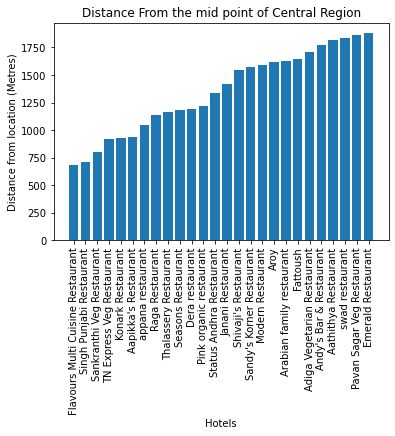

Minimum distance to the nearest Chinese Restaurant from core location is 685 metres


In [216]:
distance_CR_df=dataframe_filtered[['name','categories','distance','lat','lng']].sort_values('distance')

def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(distance_CR_df.name))
    plt.bar(distance_CR_df.name, distance_CR_df.distance)
    plt.xlabel('Hotels')
    plt.ylabel('Distance from location (Metres)')
    plt.xticks(distance_CR_df.name,rotation=90)
    plt.title('Distance From the mid point of Central Region')
    plt.show()
plot_bar_x()
fig.write_html('Distance1.html')
print("Minimum distance to the nearest Chinese Restaurant from core location is {} metres".format(int(min(cr_df['distance']))))



### If anybody wish to start a food joint specially a 'Chinese Restaurant' in Central region, Please note the nearest Chienese Restaurent is 685m from Central region. :)

# My views about the course and journey of learning.

### It was wonderful learning experience for me in IBM Applied Data Science capstone and other courses. It gave me an opportunity to think, learn and apply Data science to the real-life problems. 



# A Big Thank to Coursera!